In [1495]:
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt

## 2021 Kaggle Machine Learning & Data Science Survey

### Dataset:  
Industry-wide survey of the state of data science and machine learning with **25,973** responses!

### Objective:
**Tell a data story** about a subset of the data science community represented in this survey, through a combination of both **narrative text** and **data exploration**. A “story” could be defined any number of ways, and that’s deliberate. The challenge is to deeply explore (through data) the impact, priorities, or concerns of a specific group of data science and machine learning practitioners. That group can be defined in the macro (for example: anyone who does most of their coding in Python) or the micro (for example: female data science students studying machine learning in masters programs). This is an opportunity to be creative and tell the story of a community you identify with or are passionate about!
- **Composition** - Is there a clear narrative thread to the story that’s articulated and supported by data? The subject should be well defined, well researched, and well supported through the use of data and visualizations.
- **Originality** - Does the reader learn something new through this submission? Or is the reader challenged to think about something in a new way? A great entry will be informative, thought provoking, and fresh all at the same time.
- **Documentation** - Are your code, and notebook, and additional data sources well documented so a reader can understand what you did? Are your sources clearly cited? A high quality analysis should be concise and clear at each step so the rationale is easy to follow and the process is reproducible

### My Take
Women > 40 years

### Functions

In [1496]:
df_result = pd.DataFrame()

In [1497]:
def percent(val, total):
    return round(100 * val/total, 2)

def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

In [1498]:
def convert2percent(df, col, total_col):
    df[col] = df[col]/ df[total_col]
    return df[col].apply(lambda x: round(x*100,2))

def createNewCol(df_old, oldCol, df_new, newCol, value):
    df_new[newCol] = df_old[oldCol]
    # strip the value of the leading and trailing empty spaces
    df_new.loc[~df_new[newCol].isnull(), newCol] = df_new[~df_new[newCol].isnull()][newCol].apply(lambda x: x.strip())
    return  df_new[newCol].apply(lambda x: 1 if x== value else 0)

def compare(df, df_overall, df_specific, cat_other, col_other):
    # Create a df with the overall IDE users as percentage
    df_all = pd.DataFrame()
    df_all.loc['Count','Overall']=df.shape[0]
    df_all = pd.concat([df_all, df_specific])
    df_all.loc[cat_other,'Overall']=df_all.loc[cat_other,'Overall']/len(col_other)
    df_all['Overall'] = df_all['Overall'].apply(lambda x: round((x/df.shape[0])*100,2))
    #df_pl_all

    # Create different df for woman < 40 and woman > 40
    df_woman_lt40 = df_overall.loc[('<40', 'Woman'),:].to_frame()#; print("df_pl_woman_lt40\n", df_pl_woman_lt40);print()
    df_woman_gt40 = df_overall.loc[('>40', 'Woman'),:].to_frame()#; print("df_pl_woman_gt40\n", df_pl_woman_gt40)

    # Concatenate the overall and the woman < 40 and woman > 40 data 
    df_temp = pd.concat([df_all, df_woman_lt40, df_woman_gt40], axis=1, join='inner')
    print(df_temp)
    ax = df_temp.plot.bar( ylim=(0,100),figsize=(15, 6));annotate(ax, "Overall")
    return df_temp

# Create a df with users wrt Age-group and Gender 
def createSpecificAndSummary(df,topcol1, topcol2, topcol3, othercol, nonecol, othercols):
    df_temp = df.agg({topcol1:np.sum,topcol2:np.sum,topcol3:np.sum, othercol:np.sum, nonecol:np.sum}).to_frame()
    df_temp.rename(columns={0:"Overall"}, inplace=True)
    print(df_temp)

    df_summary = df.groupby(by=['AgeGroup','Gender']).agg({'AgeGroup':'count',topcol1:np.sum,topcol2:np.sum,topcol3:np.sum, othercol:np.sum, nonecol:np.sum})
    df_summary.rename(columns={"AgeGroup":"Count"}, inplace=True)

    df_summary[topcol1] = convert2percent(df_summary,topcol1,"Count")
    df_summary[topcol2] = convert2percent(df_summary,topcol2,"Count")
    df_summary[topcol3] = convert2percent(df_summary,topcol3,"Count")

    df_summary[othercol]  = df_summary[othercol]/ df_summary["Count"]
    df_summary[othercol]  = df_summary[othercol].apply(lambda x: round(x*100/len(othercols),2))

    df_summary[nonecol]   = convert2percent(df_summary,nonecol,"Count")
    df_summary['Count']   = df_summary['Count'].apply(lambda x: round((x/df.shape[0])*100,2))
    return df_temp, df_summary

def summarise(df, df_new, cat, cols, cols_other, 
                        top1col1, top1col2, top1val, 
                        top2col1, top2col2, top2val, 
                        top3col1, top3col2, top3val, nonecol1  ):

    COL_COUNT = f'{cat}-Count'
    COL_OTHER = f'{cat}-Other'
    COL_NONE  = f'{cat}-None'

    df_new[COL_COUNT]  = df[cols].count(axis=1)
    df_new[top1col2]   = createNewCol(df, top1col1 , df_new, top1col2, top1val)
    df_new[top2col2]   = createNewCol(df, top2col1 , df_new, top2col2, top2val)
    df_new[top3col2]   = createNewCol(df, top3col1 , df_new, top3col2, top3val)

    df_new[COL_NONE]   = createNewCol(df, nonecol1, df_new, COL_NONE, "None")
    df_new[COL_OTHER]  = df[cols_other].count(axis=1) 
    df_new[COL_COUNT]  = df[cols].count(axis=1) # None is not considered
    print(df_new.head())

    df_result.loc[cat,'Count-Median'] = df_new[COL_COUNT].median()
    df_result.loc[cat,'W<40-Median'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='<40')][COL_COUNT].median()
    df_result.loc[cat,'W>40-Median'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='>40')][COL_COUNT].median()

    df_result.loc[cat,'Count-Max'] = df_new[COL_COUNT].max()
    df_result.loc[cat,'W<40-Max'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='<40')][COL_COUNT].max()
    df_result.loc[cat,'W>40-Max'] =df_new[(df_new['Gender']=='Woman')&(df_new['AgeGroup']=='>40')][COL_COUNT].max()

    # Create a df with the IDE and total number of IDE users
    df_temp, df_summary = createSpecificAndSummary(df_new, top1col2, top2col2, top3col2, COL_OTHER, COL_NONE, cols_other)

    df_ = compare(df, df_summary, df_temp, COL_OTHER, cols_other)
    plotBox(df_new, COL_COUNT)  
    return df_ 

def plotBox(df, col):
    df_man = df[df['Gender']=='Man'][['AgeGroup', col]];print(df_man.head())
    df_woman = df[df['Gender']=='Woman'][['AgeGroup', col]];print(df_woman.head())
    plt.figure(figsize=(18, 5), dpi=80)

    ax = plt.subplot(1, 4, 1); df_woman[df_woman['AgeGroup']=='<40'].hist(ax=ax); plt.title('Woman < 40')
    ax = plt.subplot(1, 4, 2); df_woman[df_woman['AgeGroup']=='>40'].hist(ax=ax); plt.title('Woman > 40') 
    ax = plt.subplot(1, 4, 3); df_man.boxplot(by='AgeGroup', ax=ax); ax.set_title('Man')        
    ax = plt.subplot(1, 4, 4); df_woman.boxplot(by='AgeGroup',ax=ax); ax.set_title('Woman')    

### Read dataset

In [1499]:
df = pd.read_csv('data/kaggle_survey_2021_responses.csv', header=[0,1])

/Users/sreedevigattu/sree/projects/mlds/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (195,201) have mixed types.Specify dtype option on import or set low_memory=False.



In [1500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25973 entries, 0 to 25972
Columns: 369 entries, ('Time from Start to Finish (seconds)', 'Duration (in seconds)') to ('Q38_B_OTHER', 'In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - Other')
dtypes: float64(8), int64(1), object(360)
memory usage: 73.1+ MB


In [1501]:
print(df.columns.tolist())

[('Time from Start to Finish (seconds)', 'Duration (in seconds)'), ('Q1', 'What is your age (# years)?'), ('Q2', 'What is your gender? - Selected Choice'), ('Q3', 'In which country do you currently reside?'), ('Q4', 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'), ('Q5', 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'), ('Q6', 'For how many years have you been writing code and/or programming?'), ('Q7_Part_1', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python'), ('Q7_Part_2', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R'), ('Q7_Part_3', 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL'), ('Q7_Part_4', 'What programming languages do you use on a regular basis? (Select all that apply) - Sele

In [1502]:
df.iloc[0,:].to_frame().to_csv("Columns.csv")

<AxesSubplot:>

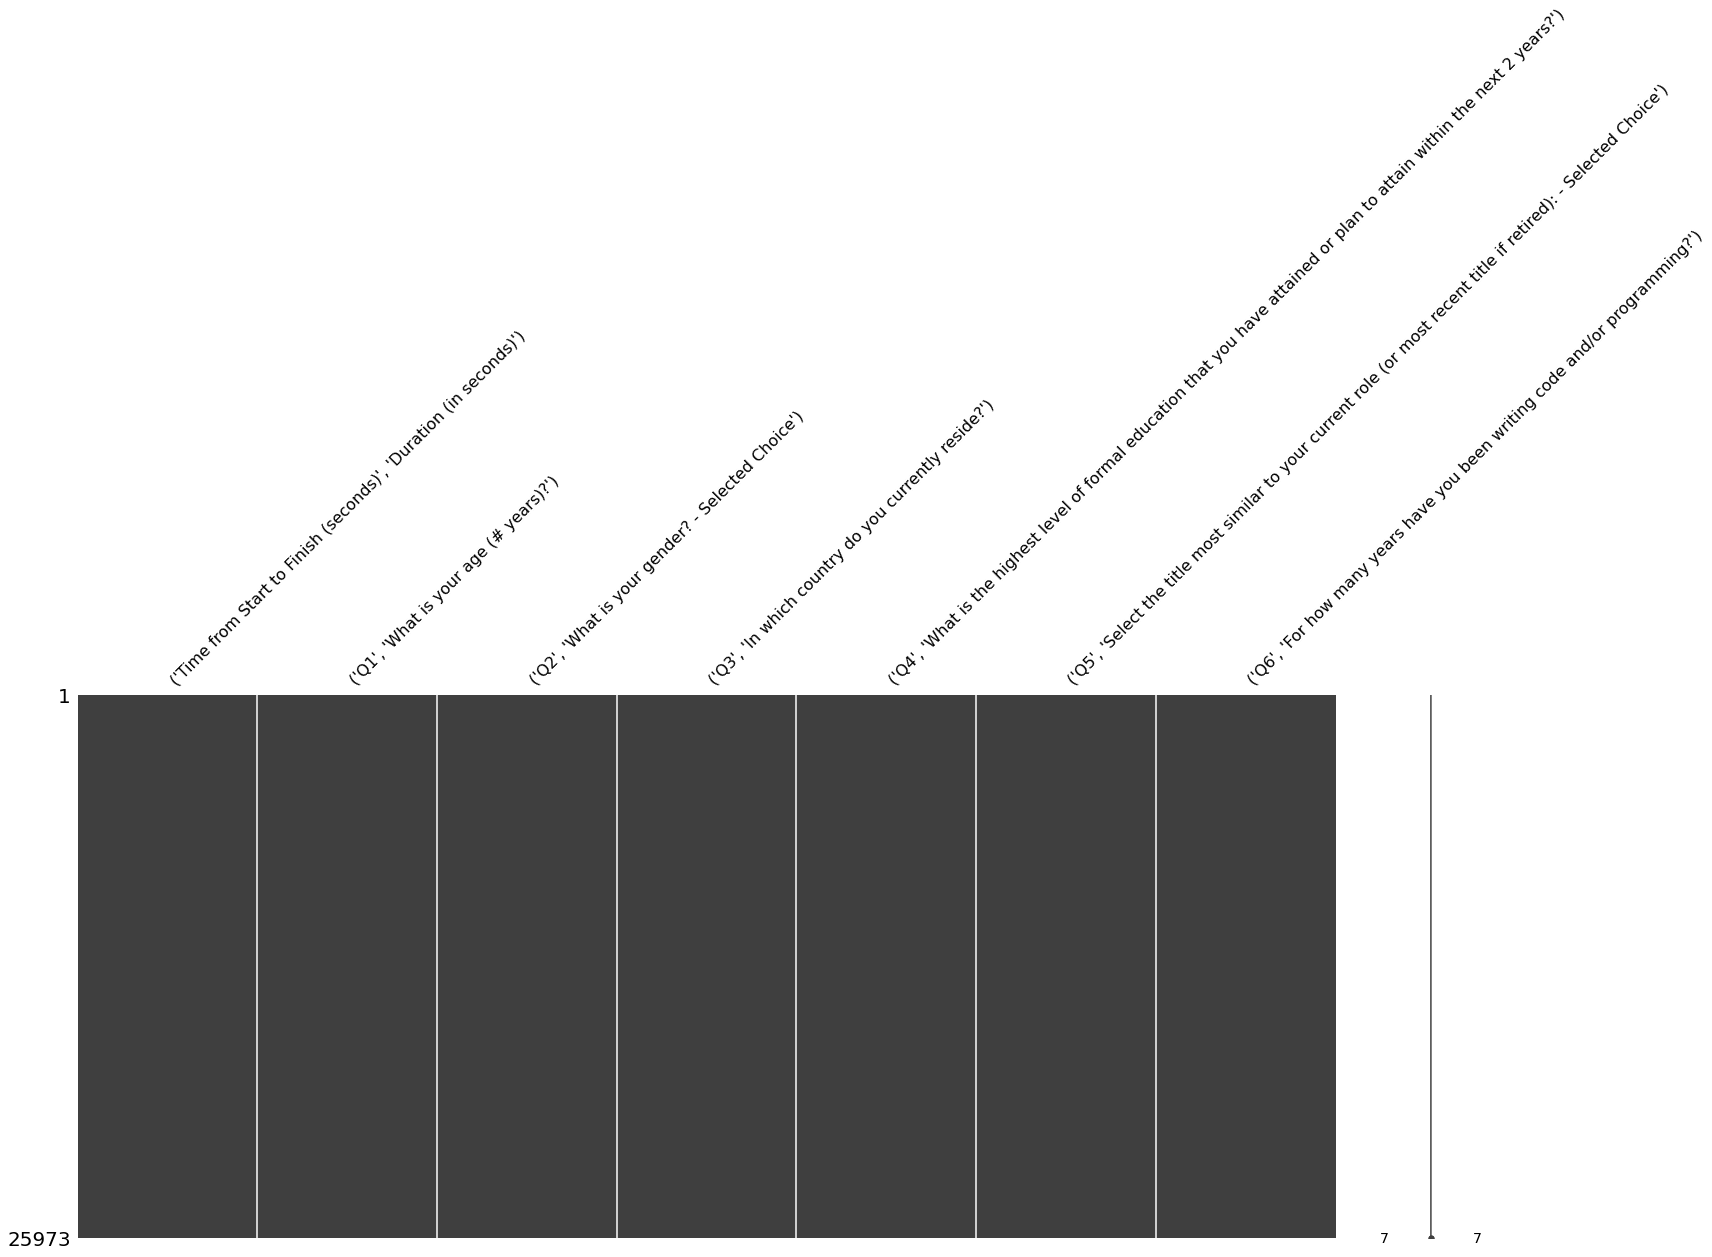

In [1503]:
msno.matrix(df.iloc[:,:7])

### Age and Gender

In [1504]:
df_new = pd.DataFrame()
df_new['Age'] = df['Q1', 'What is your age (# years)?']
df_new['Gender'] = df['Q2', 'What is your gender? - Selected Choice']
df_new['Country'] = df['Q3', 'In which country do you currently reside?']
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25973 entries, 0 to 25972
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Age      25973 non-null  object
 1   Gender   25973 non-null  object
 2   Country  25973 non-null  object
dtypes: object(3)
memory usage: 608.9+ KB


In [1505]:
df_new.groupby(by='Age').agg({"Age":'count'}).rename(columns={'Age':'Count'}).reset_index(inplace=True)
print(df_new['Gender'].value_counts())
df_new

Man                        20598
Woman                       4890
Prefer not to say            355
Nonbinary                     88
Prefer to self-describe       42
Name: Gender, dtype: int64


,Age,Gender,Country
0,50-54,Man,India
1,50-54,Man,Indonesia
2,22-24,Man,Pakistan
3,45-49,Man,Mexico
4,45-49,Man,India
...,...,...,...
25968,30-34,Man,Egypt
25969,22-24,Man,China
25970,50-54,Man,Sweden
25971,45-49,Man,United States of America


In [1506]:
df_new['Gender'] = df_new['Gender'].apply(lambda x: x if x in ['Man', 'Woman'] else 'Other')
df_new["AgeGroup"] = df_new['Age'].apply(lambda x: '<40' if x in ['18-21', '22-24', '25-29', '30-34', '35-39'] else '>40')
df_new.head()

,Age,Gender,Country,AgeGroup
0,50-54,Man,India,>40
1,50-54,Man,Indonesia,>40
2,22-24,Man,Pakistan,<40
3,45-49,Man,Mexico,>40
4,45-49,Man,India,>40


In [1507]:
df_new.groupby(by=['AgeGroup','Gender']).agg({'AgeGroup':'count'})

AgeGroup
AgeGroup Gender          
<40      Man        15956
         Other        368
         Woman       4147
>40      Man         4642
         Other        117
         Woman        743

In [1538]:
top10countries = df_new.groupby(by='Country').agg({'Country':'count'}).rename(columns={'Country':'Count'}).sort_values(by='Count', ascending=False)[:10].index.tolist()
print(top10countries)

['India', 'United States of America', 'Other', 'Japan', 'China', 'Brazil', 'Russia', 'Nigeria', 'United Kingdom of Great Britain and Northern Ireland', 'Pakistan']


In [1526]:
df_xxx = df_new.groupby(by=['AgeGroup','Gender','Country']).agg({'AgeGroup':'count'})
df_xxx.rename(columns={'AgeGroup':'Count'}, inplace=True)
df_xxx

Count
AgeGroup Gender Country                                                  
<40      Man    Algeria                                                27
                Argentina                                              91
                Australia                                             114
                Austria                                                25
                Bangladesh                                            260
...                                                                   ...
>40      Woman  Turkey                                                  9
                Ukraine                                                 1
                United Arab Emirates                                    6
                United Kingdom of Great Britain and Northern Ir...     34
                United States of America                              210

[329 rows x 1 columns]

In [1540]:
pd.pivot_table(df_xxx, index=['Gender', 'AgeGroup'],columns = ['Country'], values ='Count', aggfunc=np.sum).loc[['Man','Woman'],top10countries]

Country           India  United States of America  Other  Japan  China  \
Gender AgeGroup                                                          
Man    <40       5230.0                    1110.0  762.0  514.0  648.0   
       >40        451.0                     839.0  242.0  322.0   24.0   
Woman  <40       1568.0                     396.0  186.0   41.0  104.0   
       >40         88.0                     210.0   41.0   27.0    2.0   

Country          Brazil  Russia  Nigeria  \
Gender AgeGroup                            
Man    <40        464.0   483.0    532.0   
       >40        200.0   147.0     62.0   
Woman  <40         64.0    92.0    102.0   
       >40         17.0    12.0      5.0   

Country          United Kingdom of Great Britain and Northern Ireland  \
Gender AgeGroup                                                         
Man    <40                                                   276.0      
       >40                                                   153.0      
Woman  <40                                                    79.0      
       >40                                                    34.0      

Country          Pakistan  
Gender AgeGroup            
Man    <40          400.0  
       >40           48.0  
Woman  <40           78.0  
       >40            3.0

In [1519]:
pd.pivot_table(df_new[['Gender','Country','AgeGroup']], index=['AgeGroup'], columns = ['Country'], values ='AgeGroup', aggfunc='count')[['India', 'United States of America']]

Country,India,United States of America
AgeGroup,,
<40,6891,1566
>40,543,1084


In [ ]:
pd.pivot_table(df_new, index='Gender', columns = 'Age', values ='Age', aggfunc='count')

In [ ]:
df_ = df_new.groupby(by=['Age','Gender']).agg({'Gender':'count'}).rename(columns={'Gender':'Count'})
df_.reset_index(inplace=True)
df_

In [ ]:
import numpy as np

In [ ]:
df_summary = pd.pivot_table(data = df_,  values='Count', index=['Age'], columns=['Gender'], aggfunc=np.sum, fill_value=0)
df_summary

In [ ]:
#df_summary['Other'] = df_summary['Prefer not to say'] + df_summary['Nonbinary'] + df_summary['Prefer to self-describe']
df_summary['Count'] = df_summary['Man'] + df_summary['Woman'] + df_summary['Other']
#df_summary.drop(columns=['Prefer not to say','Nonbinary', 'Prefer to self-describe'],inplace=True)
df_summary.columns = ['Gender-Man','Gender-Woman', 'Gender-Other','Count']
df_summary.reset_index(inplace=True)
df_summary = df_summary[['Age', 'Count', 'Gender-Man', 'Gender-Woman', 'Gender-Other']]
df_summary

In [ ]:
df_summary['Age'].values

In [ ]:
df_summary["AgeGroup"] = df_summary['Age'].apply(lambda x: '<40' if x in ['18-21', '22-24', '25-29', '30-34', '35-39'] else '>40')

In [ ]:
import plotly.graph_objects as go
NODES = dict( #           0                               1                          2        3       4           5
            label = ["18-21", "22-24", "25-29", "Gender-Man", "Gender-Woman", "Gender-Other"],
            color = ["seagreen", "dodgerblue", "orange", "gold", "silver", "brown" ],)

LINKS = dict(   source = [  0,  0,  0,  1,  1,  1,  2,  2,  2], # The origin or the source nodes of the link
                target = [  3,  4,  5,  3,  4,  5,  3,  4,  5], # The destination or the target nodes of the link
                value =  [ 3696, 1117, 88, 3643, 963, 88, 3859, 994, 78], # The width (quantity) of the links 
                # Color of the links 
                # Target Node:    3-Gold          4 -Silver        5-Bronze           
                color =     [   "lightgreen",   "lightgreen",   "lightgreen",      # Source Node: 0 - United States of America
                                "lightskyblue", "lightskyblue", "lightskyblue",    # Source Node: 1 - People's Republic of China
                                "bisque",       "bisque",       "bisque"],)        # Source Node: 2 - Japan

data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.update_layout(title="Age - Gender",  font_size=16)
fig.show()

In [ ]:
import plotly.express as px
fig = px.treemap(
    names = ["Eve","Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    parents = ["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve"]
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
df_summary.head()

In [ ]:
df_age = df_summary.groupby(by='AgeGroup').agg({'Count':np.sum, 'Gender-Man': np.sum, 'Gender-Woman':np.sum})
df_age.reset_index(inplace=True)
df_age

In [ ]:
import plotly.express as px
fig = px.treemap(
    names = ["Total","<40", "Men", "Women",">40", "Men->40", "Women->40"],
    parents = ["", "Total", "<40", "<40", "Total", ">40", ">40"]
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
import plotly.express as px
df_ex = px.data.tips()
fig = px.treemap(df_ex, path=[px.Constant("all"), 'day', 'time', 'sex'], values='total_bill')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
df.head()

In [ ]:
df_["AgeGroup"] = df_['Age'].apply(lambda x: '<40' if x in ['18-21', '22-24', '25-29', '30-34', '35-39'] else '>40')
df_['Gender'] = df_['Gender'].apply(lambda x: x if x in ['Man', 'Woman'] else 'Other')
df_.head()

In [ ]:
fig = px.treemap(df_, path=[px.Constant("all"), 'Age', 'Gender'], values='Count')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
fig = px.treemap(df_, path=[px.Constant("all"), 'AgeGroup', 'Gender'], values='Count')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

## TODO: Change the labels (percentages?) and colors

### Programming Languages

In [ ]:
COLS_PL = list(filter(lambda x: True if x[0][:2]=='Q7' and x[0][-2:] != '12' else False, df.columns.to_list())) # TODO: 'None' should not be considered here
COLS_PL_OTHER = list(filter(lambda x: True if x[0][:2]=='Q7' and x[0][-2:] not in ['_1','_2','_3','12'] else False, df.columns.to_list()))
print("COLS_PL", end=': ');[print(col[0], end=', ') for col in COLS_PL]; print()
print("COLS_PL_OTHER", end=': ');[print(col[0], end=', ') for col in COLS_PL_OTHER]; print()
df[COLS_PL].head()

In [ ]:
df[COLS_PL].count().sort_values(ascending=False)

In [ ]:
df_new.head()

In [ ]:
df_summary = summarise(df, df_new, 'PL', COLS_PL, COLS_PL_OTHER, 
            'Q7_Part_1', 'Python', "Python",
            'Q7_Part_2', 'R', "R",
            'Q7_Part_3', 'SQL', "SQL", 
            'Q7_Part_12')

In [ ]:
df_result

In [ ]:
plt.figure(figsize=(18, 5), dpi=80)

ax = plt.subplot(1, 4, 1); df_new.hist(ax=ax)
ax = plt.subplot(1, 4, 2); df_new.hist(ax=ax)
ax = plt.subplot(1, 4, 3); df_new.boxplot(by='AgeGroup', ax=ax)
ax = plt.subplot(1, 4, 4); df_new.boxplot(by='AgeGroup',ax=ax)

In [ ]:
# Create a new column IDE Count to store the number of IDEs used
df_new['PL-Count'] = df[COLS_PL].count(axis=1)
df_new.head()

df_new['Python'] = df['Q7_Part_1']; df_new['Python'] = df_new['Python'].apply(lambda x: 1 if x=="Python" else 0)
df_new['R'] = df['Q7_Part_2'];      df_new['R'] = df_new['R'].apply(lambda x: 1 if x=="R" else 0)
df_new['SQL'] = df['Q7_Part_3'];    df_new['SQL'] = df_new['SQL'].apply(lambda x: 1 if x=="SQL" else 0)
df_new['None'] = df['Q7_Part_12'];  df_new['None'] = df_new['None'].apply(lambda x: 1 if x=="None" else 0)
df_new['Other'] = df[COLS_PL_OTHER].count(axis=1) # df_new['Other'] = df['Q7_Part_4'] + df['Q7_Part_5'] + df['Q7_Part_6'] + df['Q7_Part_7'] + df['Q7_Part_8'] + df['Q7_Part_9'] + df['Q7_Part_10'] + df['Q7_Part_11'] + df['Q7_OTHER']
df_new['ProgLang'] = df['Q8']
df_new['ProgLangCount'] = df[COLS_PL].count(axis=1) # None is not considered
df_new.head()


# Create a df with the IDE and total number of IDE users
df_temp, df_pl_summary = createSpecificAndSummary(df_new, 'Python', 'R', 'SQL', 'Other', 'None',COLS_PL_OTHER)
compare(df, df_pl_summary, df_temp, 'Other', COLS_PL_OTHER)
plotBox(df_new, 'PL-Count')

- A mere 3% of the total community is >40 women.
- 66-44 use Python-SQL
- 4.4 use None

In [ ]:
print(df_new['Python'].sum(), df_new[df_new['Python']==0]['Python'].count(), df_new.shape[0])

In [ ]:
def abc(label, lt40, gt40):
    print(f"{label:5}    <40: {percent(lt40,df.shape[0]):2.2f}%    >40: {percent(gt40,df.shape[0]):2.2f}%")

abc("Woman", 4147, 743)
abc("Man", 15956, 4642)

In [ ]:
def my_value_counts(df, col):
    df_ = df['ProgLang'].value_counts(normalize=True).to_frame()
    #print(df_pl_all)
    return df_
df_pl_all = my_value_counts(df_new, 'ProgLang') 
df_pl_man = my_value_counts(df_man, 'ProgLang') 
df_pl_woman =  my_value_counts(df_woman, 'df_woman')
df_pl_woman_lt40 =  my_value_counts(df_woman[df_woman['AgeGroup']=='<40'], 'ProgLang') 
df_pl_woman_gt40 =  my_value_counts(df_woman[df_woman['AgeGroup']=='>40'], 'ProgLang') 
df_res = pd.merge(df_pl_man, df_pl_woman, left_index=True, right_index=True,suffixes=['_m','_w'])
df_res = pd.merge(df_res, df_pl_woman_lt40, left_index=True, right_index=True)
df_res = pd.merge(df_res, df_pl_woman_gt40, left_index=True, right_index=True,suffixes=['_w_lt40','_w_gt40'])
df_res = pd.merge(df_pl_all, df_res, left_index=True, right_index=True)
round(df_res*100,1)
df_res.plot.bar(figsize=(15,5), logy=True)

### IDE

In [ ]:
# Get the list of IDE columns (apart from None)
COLS_IDE_NONE = ['Q9_Part_12']
COLS_IDE = list(filter(lambda x: True if x[0][:2]=='Q9' and x[0] not in COLS_IDE_NONE else False, df.columns.to_list())) #[-2:] != '12'
# Sort the IDEs based on the count
df[COLS_IDE].count().sort_values(ascending=False)

In [ ]:
# Categorise the list of columns that are top3 and not top3
COLS_IDE_TOP3 = ['Q9_Part_11','Q9_Part_4','Q9_Part_5']
COLS_IDE_OTHER = list(filter(lambda x: True if x[0] not in COLS_IDE_TOP3 else False, COLS_IDE))

print(f"{'COLS_IDE':14} {len(COLS_IDE):2}", end=': ');            [print(col[0], end=', ') for col in COLS_IDE]; print()
print(f"{'COLS_IDE_TOP3':14} {len(COLS_IDE_TOP3):2}", end=': ');  [print(col, end=', ') for col in COLS_IDE_TOP3]; print()
print(f"{'COLS_IDE_OTHER':14} {len(COLS_IDE_OTHER):2}", end=': ');[print(col[0], end=', ') for col in COLS_IDE_OTHER]; print()
print(f"{'COLS_IDE_NONE':14} {len(COLS_IDE_NONE):2}", end=': ');  [print(col, end=', ') for col in COLS_IDE_NONE]; print()

df[COLS_IDE].head()

In [ ]:
summarise(df, df_new, 'IDE', COLS_IDE, COLS_IDE_OTHER, 
            'Q9_Part_11', 'JupyterNB', "Jupyter Notebook",
            'Q9_Part_4', 'VSCode', "Visual Studio Code (VSCode)",
            'Q9_Part_5', 'PyCharm', "PyCharm", 
            'Q9_Part_12')

- Similar trend in the IDE usage as well.
- None is a little higher than the other categories

### Hosted Notebooks

In [ ]:
# Get the list of IDE columns (apart from None)
COLS_HNB_NONE = ['Q10_Part_16']
COLS_HNB = list(filter(lambda x: True if x[0][:3]=='Q10' and x[0] not in COLS_HNB_NONE else False, df.columns.to_list()))
# Sort the NBs based on the count
df[COLS_HNB].count().sort_values(ascending=False)

In [ ]:
# Categorise the list of columns that are top3 and not top3
COLS_HNB_TOP3 = ['Q10_Part_2','Q10_Part_1','Q10_Part_10']
COLS_HNB_OTHER = list(filter(lambda x: True if x[0] not in COLS_HNB_TOP3 else False, COLS_HNB))

print(f"{'COLS_HNB':19} {len(COLS_HNB):2d}", end=': ');               [print(col[0], end=', ') for col in COLS_HNB]; print()
print(f"{'COLS_HNB_TOP3':19} {len(COLS_HNB_TOP3):2d}", end=': ');     [print(col, end=', ') for col in COLS_HNB_TOP3]; print()
print(f"{'COLS_HNB_OTHER':19} {len(COLS_HNB_OTHER):2d}", end=': ');   [print(col[0], end=', ') for col in COLS_HNB_OTHER]; print()
print(f"{'COLS_HNB_NONE':19} {len(COLS_HNB_NONE):2d}", end=': ');     [print(col, end=', ') for col in COLS_HNB_NONE]; print()

df[COLS_HNB].head()

In [ ]:
summarise(df, df_new, 'HNB', COLS_HNB, COLS_HNB_OTHER, 
            'Q10_Part_2', 'HNB-Colab', "Colab Notebooks",
            'Q10_Part_1', 'HNB-Kaggle', "Kaggle Notebooks",
            'Q10_Part_10', 'HNB-Google', "Google Cloud Notebooks (AI Platform / Vertex AI)", 
            'Q10_Part_16')

### Hardware

In [ ]:
# Get the list of IDE columns (apart from None)
COLS_HW_NONE = ['Q12_Part_5']
COLS_HW = list(filter(lambda x: True if x[0][:3]=='Q12' and x[0] not in COLS_HW_NONE else False, df.columns.to_list()))
# Sort the NBs based on the count
df[COLS_HW].count().sort_values(ascending=False)

In [ ]:
# Categorise the list of columns that are top3 and not top3
COLS_HW_TOP3 = ['Q12_Part_1','Q10_Part_2','Q10_Part_4']
COLS_HW_OTHER = list(filter(lambda x: True if x[0] not in COLS_HW_TOP3 else False, COLS_HW))

print(f"{'COLS_HW':14} {len(COLS_HW):2d}", end=': ');               [print(col[0], end=', ') for col in COLS_HW]; print()
print(f"{'COLS_HW_TOP3':14} {len(COLS_HW_TOP3):2d}", end=': ');     [print(col, end=', ') for col in COLS_HW_TOP3]; print()
print(f"{'COLS_HW_OTHER':14} {len(COLS_HW_OTHER):2d}", end=': ');   [print(col[0], end=', ') for col in COLS_HW_OTHER]; print()
print(f"{'COLS_HW_NONE':14} {len(COLS_HW_NONE):2d}", end=': ');     [print(col, end=', ') for col in COLS_HW_NONE]; print()

df[COLS_HW].head()

In [ ]:
summarise(df, df_new, 'HW', COLS_HW, COLS_HW_OTHER, 
            'Q12_Part_1', 'HW-Nvidia', "NVIDIA GPUs",
            'Q12_Part_2', 'HW-GCTPU', "Google Cloud TPUs",
            'Q12_Part_4', 'HW-AWSIC', "AWS Inferentia Chips", 
            'Q12_Part_5')

### XXX

In [ ]:
# Get the list of IDE columns (apart from None)
COLS_HNB_NONE = ['Q10_Part_16']
COLS_HNB = list(filter(lambda x: True if x[0][:3]=='Q10' and x[0] not in COLS_HNB_NONE else False, df.columns.to_list()))
# Sort the NBs based on the count
df[COLS_HNB].count().sort_values(ascending=False)

#--------------------
# Categorise the list of columns that are top3 and not top3
COLS_HNB_TOP3 = ['Q10_Part_2','Q10_Part_1','Q10_Part_10']
COLS_HNB_OTHER = list(filter(lambda x: True if x[0] not in COLS_HNB_TOP3 else False, COLS_HNB))

print(f"{'COLS_HNB':19} {len(COLS_HNB):2d}", end=': ');               [print(col[0], end=', ') for col in COLS_HNB]; print()
print(f"{'COLS_HNB_TOP3':19} {len(COLS_HNB_TOP3):2d}", end=': ');     [print(col, end=', ') for col in COLS_HNB_TOP3]; print()
print(f"{'COLS_HNB_OTHER':19} {len(COLS_HNB_OTHER):2d}", end=': ');   [print(col[0], end=', ') for col in COLS_HNB_OTHER]; print()
print(f"{'COLS_HNB_NONE':19} {len(COLS_HNB_NONE):2d}", end=': ');     [print(col, end=', ') for col in COLS_HNB_NONE]; print()

df[COLS_HNB].head()
#--------------------
summarise(df, df_new, 'HW', COLS_HW, COLS_HW_OTHER, 
            'Q12_Part_1', 'HW-Nvidia', "NVIDIA GPUs",
            'Q12_Part_2', 'HW-GCTPU', "Google Cloud TPUs",
            'Q12_Part_4', 'HW-AWSIC', "AWS Inferentia Chips", 
            'Q12_Part_5')

### Next

In [ ]:
COLS_XXX = ['Age','Gender','AgeGroup','PL-Count','PL-None','IDE-Count','IDE-None','HNB-Count','HNB-None','HW-Count','HW-None']
COLS_XXX_INT = ['PL-Count','PL-None','IDE-Count','IDE-None','HNB-Count','HNB-None','HW-Count','HW-None']
COLS_XXX_COUNT = ['PL-Count','IDE-Count','HNB-Count','HW-Count']
COLS_XXX_NONE = ['PL-None','IDE-None','HNB-None','HW-None']
df_new[COLS_XXX].head()

In [ ]:
# TODO: Percentage as well
# Concatenate the overall and the woman < 40 and woman > 40 data 
df_temp = pd.concat([df_new[COLS_XXX_INT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_XXX_INT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_XXX_INT].sum()], 
                    axis=1, join='inner')
df_temp.rename(columns={0:'Overall',1:'<40',2:'>40'}, inplace=True)
print(df_temp)
ax = df_temp.plot.bar(logy=True, figsize=(15, 6));annotate(ax, "Overall") #ylim=(0,100),

In [ ]:
# Concatenate the overall and the woman < 40 and woman > 40 data 
df_temp = pd.concat([
                    df_new[COLS_XXX_COUNT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_XXX_COUNT].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_XXX_COUNT].sum()], 
                    axis=1, join='inner')
df_temp.rename(columns={0:'Overall',1:'<40',2:'>40'}, inplace=True)
print(df_temp)
ax = df_temp.plot.bar(logy=True, figsize=(15, 6));annotate(ax, "Overall") #ylim=(0,100),

### Using NONE

In [ ]:
# Concatenate the overall and the woman < 40 and woman > 40 data 
df_temp = pd.concat([df_new[COLS_XXX_NONE].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')][COLS_XXX_NONE].sum(), 
                    df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')][COLS_XXX_NONE].sum()], 
                    axis=1, join='inner')
df_temp.rename(columns={0:'Overall',1:'Woman<40',2:'Woman>40'}, inplace=True)
df_temp['Overall'] = round((df_temp['Overall']/df.shape[0])*100,2)
df_temp['Woman<40'] = round((df_temp['Woman<40']/df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='<40')].shape[0])*100,2)
df_temp['Woman>40'] = round((df_temp['Woman>40']/df_new[(df_new['Gender']=='Woman') & (df_new['AgeGroup']=='>40')].shape[0])*100,2)
print(df_temp)
ax = df_temp.plot.bar(logy=True, figsize=(15, 6));annotate(ax, "Overall") #ylim=(0,100),

### Median Values

In [ ]:
df_result